# Chains in LangChain

## Outline
- LLMChain
- Sequential Chains
    - SimpleSequentialChain
    - SequentialChain
- Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip -q install pandas

In [3]:
import pandas as pd
df = pd.read_csv('./data/Data.csv')

In [4]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


In [5]:
from langchain.chains import LLMChain, SequentialChain,SimpleSequentialChain
from langchain.prompts.prompt import PromptTemplate
from langchain_community.chat_models import BedrockChat
import boto3

model_id='anthropic.claude-3-sonnet-20240229-v1:0'

    
def get_llm_model(model_id: str, temperature: float) -> BedrockChat:
    client = get_bedrock_runtime_client(
        region_name="us-east-1"
    )
    return BedrockChat(
        client=client,
        model_id=model_id,
        model_kwargs={"temperature": temperature},
    )
    
def get_bedrock_runtime_client(region_name: str):
    return boto3.client(service_name="bedrock-runtime", region_name=region_name)


## LLMChain

In [6]:
from langchain_core.prompts import ChatPromptTemplate

llm=get_llm_model(model_id=model_id,temperature=0)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `BedrockChat` was deprecated in LangChain 0.0.34 and will be removed in 0.3. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import ChatBedrock`.
  warn_deprecated(


In [7]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [8]:
chain = LLMChain(llm=llm, prompt=prompt)

In [9]:
product = "Queen Size Sheet Set"
#prompt.invoke(product)
chain.run(product)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'Here are some potential good name ideas for a company that makes queen size sheet sets:\n\n1. Queen\'s Linen\n2. Royal Bedding Co.\n3. Majesty Sheets\n4. Regal Linens\n5. Queenly Threads\n6. Crown Linen Essentials\n7. Monarch Bedding\n8. Sovereign Sleep Textiles\n9. Royalty Bed Linens\n10. Queen\'s Slumber Sheets\n\nThe names play on the "queen" theme by using words like royal, majesty, regal, monarch, sovereign, royalty, crown, etc. This connects the name to the queen size sheet sets the company produces. Words like linen, bedding, threads, and textiles indicate the products are bed linens/sheets.'

## SimpleSequentialChain
Single Input Single Output

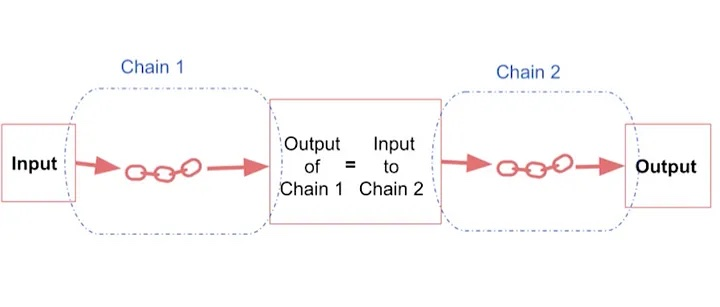


In [10]:
from langchain.chains import SimpleSequentialChain

In [11]:
llm=get_llm_model(model_id=model_id,temperature=0)
# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [12]:

# Here the input is country coming from the chain1

# prompt template 2
second_prompt = """Write a 20 words description for the following company:{company_name}"""


prompt_template2 = PromptTemplate(input_variables=['company_name'], template=second_prompt)
chain2 = LLMChain(llm=llm, prompt=prompt_template2)

# chain 2
chain_two = LLMChain(llm=llm, prompt=prompt_template2)

In [13]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True)


In [14]:
overall_simple_chain.run(product)




> Entering new SimpleSequentialChain chain...
Here are some potential good name ideas for a company that makes queen size sheet sets:

1. Queen's Linen
2. Royal Bedding Co.
3. Majesty Sheets
4. Regal Linens
5. Queenly Threads
6. Crown Linen Essentials
7. Monarch Bedding
8. Sovereign Sleep Textiles
9. Royalty Bed Linens
10. Queen's Slumber Sheets

The names play on the "queen" theme by using words like royal, majesty, regal, monarch, sovereign, royalty, crown, etc. This connects the name to the queen size sheet sets the company produces. Words like linen, bedding, threads, and textiles indicate the products are bed linens/sheets.
Luxurious queen size sheet sets crafted with premium materials for regal comfort.

> Finished chain.


'Luxurious queen size sheet sets crafted with premium materials for regal comfort.'

## SequentialChain
Multiple Input Multiple Output

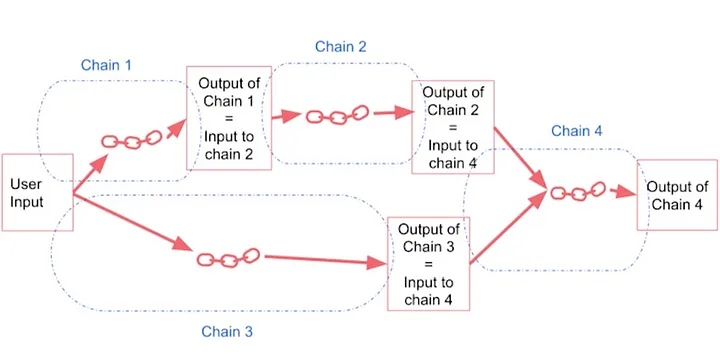

In [15]:
from langchain.chains import SequentialChain

In [16]:

first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )

In [17]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )

In [18]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

In [19]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

In [20]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary", "followup_message"],
    verbose=True
)

In [21]:
df.Review[5]

"Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?"

In [22]:
review = df.Review[5]
overall_chain(review)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "Here is my translation of the review to English:\n\nI find the taste mediocre. The foam doesn't hold, it's weird. I buy the same ones in stores and the taste is much better...\nOld batch or counterfeit!?",
 'summary': 'The review criticizes the mediocre taste, poor foam retention, and suggests the possibility of an old batch or counterfeit product, as the same product purchased in stores tastes much better.',
 'followup_message': "Voici une réponse possible en français :\n\nNous sommes désolés d'entendre que votre expérience avec notre produit n'a pas été à la hauteur de vos attentes. Nous prenons ces commentaires très au sérieux et souhaitons enquêter davantage sur ce problème. Pourriez-vous nous fournir plus de détails sur le lot spécifique que vous avez acheté, ainsi que le lieu et la dat

## Router Chain

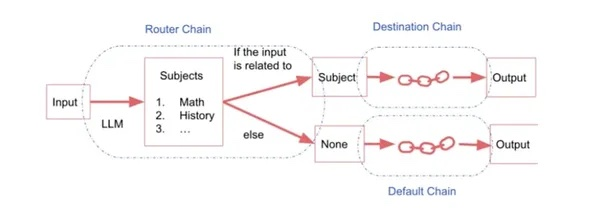

In [23]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [24]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [25]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [26]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [27]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [28]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to wrap the output with ```json (output)```)>>"""

In [29]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [30]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [31]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


'Black body radiation refers to the electromagnetic radiation emitted by an idealized object known as a black body. A black body is a hypothetical object that absorbs all electromagnetic radiation that falls on it, regardless of the wavelength or angle of incidence. It is also a perfect emitter of radiation, emitting the maximum possible amount of radiation at every wavelength for a given temperature.\n\nThe spectrum of black body radiation is continuous and depends solely on the temperature of the black body. As the temperature increases, the peak of the radiation spectrum shifts towards shorter wavelengths (higher frequencies), and the total amount of radiation emitted increases.\n\nBlack body radiation plays a crucial role in various areas of physics, including:\n\n1. Thermal radiation: The radiation emitted by any object at a non-zero temperature can be approximated as black body radiation, which is the basis for understanding thermal radiation and heat transfer processes.\n\n2. St

In [32]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'Okay, let\'s break this down step-by-step:\n\n1) We are asked to find the sum of 2 and 2\n2) 2 is a number representing a quantity\n3) + is the operation of addition\n4) To add 2 and 2:\n   We start with the first number 2\n   We then take the second number 2 \n   And combine them together into one quantity\n5) 2 + 2 = 4\n\nTherefore, the answer to the question "What is 2 + 2?" is 4.'

In [34]:
chain.run("what is python programming ?")



> Entering new MultiPromptChain chain...
computer science: {'input': 'what is python programming?'}
> Finished chain.


"Python is a high-level, interpreted, general-purpose programming language that emphasizes code readability and simplicity. It was created by Guido van Rossum in the late 1980s and has since become one of the most popular programming languages in the world, particularly in the fields of data science, machine learning, web development, automation, and scripting.\n\nPython is known for its clean and readable syntax, which makes it easy to learn and write code. It supports multiple programming paradigms, including procedural, object-oriented, and functional programming. Python's extensive standard library and vast ecosystem of third-party libraries and frameworks provide a wide range of tools and functionalities for various tasks, such as data manipulation, web development, scientific computing, and more.\n\nHere are some key features and advantages of Python:\n\n1. **Simplicity and Readability**: Python's syntax is designed to be easy to read and write, making it accessible to beginners 

In [35]:
chain.run("what is DNA ?")



> Entering new MultiPromptChain chain...
biology: {'input': 'What is DNA and what is its role in living organisms?'}

ValueError: Received invalid destination chain name 'biology'